# Project 2: Machine Model Training
#### The purpose is to distinguish between meal and no meal time series data by training a model with the given dataset and then to test for unknown data

In [ ]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import pickle
from sklearn.utils import shuffle
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.tree import DecisionTreeClassifier

### CGM (Continuous Glucose Monitor) and Insulin Datasets¶

In [ ]:
insulin_dataset_full = pd.read_csv('InsulinData.csv', low_memory = False)

In [ ]:
insulin_data = insulin_dataset_full[['Date', 'Time', 'BWZ Carb Input (grams)']]

In [ ]:
insulin_data

,Date,Time,BWZ Carb Input (grams)
0,2/12/2018,13:20:53,NaN
1,2/12/2018,13:20:48,NaN
2,2/12/2018,13:18:48,NaN
3,2/12/2018,13:18:48,NaN
4,2/12/2018,13:12:33,NaN
...,...,...,...
41430,7/24/2017,19:00:01,NaN
41431,7/24/2017,18:59:44,NaN
41432,7/24/2017,18:59:44,NaN
41433,7/24/2017,18:59:44,NaN


In [ ]:
cgm_data_set_full = pd.read_csv('CGMData.csv', low_memory = False)

In [ ]:
cgm_data = cgm_data_set_full[['Date', 'Time', 'Sensor Glucose (mg/dL)']]

In [ ]:
cgm_data.dropna(inplace = True)

### Combining Date and Time as DateTime object

In [ ]:
insulin_data['DateTime'] = pd.to_datetime(insulin_data['Date'] + ' ' + insulin_data['Time'], format = '%m/%d/%Y %H:%M:%S')
cgm_data['DateTime'] = pd.to_datetime(cgm_data['Date'] + " " + cgm_data['Time'], format = '%m/%d/%Y %H:%M:%S')

In [ ]:
insulin_data

,Date,Time,BWZ Carb Input (grams),DateTime
0,2/12/2018,13:20:53,NaN,2018-02-12 13:20:53
1,2/12/2018,13:20:48,NaN,2018-02-12 13:20:48
2,2/12/2018,13:18:48,NaN,2018-02-12 13:18:48
3,2/12/2018,13:18:48,NaN,2018-02-12 13:18:48
4,2/12/2018,13:12:33,NaN,2018-02-12 13:12:33
...,...,...,...,...
41430,7/24/2017,19:00:01,NaN,2017-07-24 19:00:01
41431,7/24/2017,18:59:44,NaN,2017-07-24 18:59:44
41432,7/24/2017,18:59:44,NaN,2017-07-24 18:59:44
41433,7/24/2017,18:59:44,NaN,2017-07-24 18:59:44


In [ ]:
cgm_data

,Date,Time,Sensor Glucose (mg/dL),DateTime
0,2/12/2018,13:22:27,118.0,2018-02-12 13:22:27
1,2/12/2018,13:17:27,122.0,2018-02-12 13:17:27
5,2/12/2018,12:57:27,124.0,2018-02-12 12:57:27
6,2/12/2018,12:52:27,126.0,2018-02-12 12:52:27
7,2/12/2018,12:47:27,127.0,2018-02-12 12:47:27
...,...,...,...,...
55338,7/25/2017,12:28:54,311.0,2017-07-25 12:28:54
55339,7/25/2017,12:23:54,311.0,2017-07-25 12:23:54
55340,7/25/2017,12:18:54,309.0,2017-07-25 12:18:54
55341,7/25/2017,12:13:54,310.0,2017-07-25 12:13:54


In [ ]:
def get_datasets(insulin_data_file_path, cgm_data_file_path, date_time_format):
    if date_time_format == '':
        date_time_format = '%m/%d/%Y %H:%M:%S'
    insulin_dataset_full = pd.read_csv(insulin_data_file_path, low_memory = False)
    insulin_data = insulin_dataset_full[['Date', 'Time', 'BWZ Carb Input (grams)']]
    cgm_data_set_full = pd.read_csv(cgm_data_file_path, low_memory = False)
    cgm_data = cgm_data_set_full[['Date', 'Time', 'Sensor Glucose (mg/dL)']]
    cgm_data.dropna(inplace = True)
    insulin_data['DateTime'] = pd.to_datetime(insulin_data['Date'] + ' ' + insulin_data['Time'], format = date_time_format)
    cgm_data['DateTime'] = pd.to_datetime(cgm_data['Date'] + " " + cgm_data['Time'], format = date_time_format)
    return insulin_data, cgm_data

## Meal Data Extraction
From the InsulinData.csv file, search the column Y (BWZ Carb Input (grams)) for a non NAN non zero value. This time indicates the start of meal consumption time tm. Meal data comprises a 2hr 30 min stretch of CGM data that starts from tm-30min and extends to tm+2hrs.

### Extracting Start of Meal Time from Insulin Data  
#### (Based on non-zero and non-NaN BWZ Carb Input (grams) value)

In [ ]:
insulin_data_carb = insulin_data[insulin_data['BWZ Carb Input (grams)'].notna() & insulin_data['BWZ Carb Input (grams)'] != 0]

In [ ]:
insulin_data_carb.rename({'DateTime' : 'MealStartDateTime'}, axis = 1, inplace = True)

#### Sorting based on Meal start time in ascending order

In [ ]:
insulin_data_carb.sort_values(by = 'MealStartDateTime', inplace = True)

In [ ]:
insulin_data_carb

,Date,Time,BWZ Carb Input (grams),MealStartDateTime
41401,7/25/2017,10:21:19,91.0,2017-07-25 10:21:19
41393,7/25/2017,10:39:46,58.0,2017-07-25 10:39:46
41347,7/25/2017,18:31:40,115.0,2017-07-25 18:31:40
41274,7/26/2017,9:27:16,72.0,2017-07-26 09:27:16
41265,7/26/2017,11:24:52,20.0,2017-07-26 11:24:52
...,...,...,...,...
222,2/11/2018,16:27:04,40.0,2018-02-11 16:27:04
207,2/11/2018,18:14:37,8.0,2018-02-11 18:14:37
188,2/11/2018,20:33:18,71.0,2018-02-11 20:33:18
129,2/12/2018,2:30:55,15.0,2018-02-12 02:30:55


In [ ]:
meal_start_times = list(insulin_data_carb['MealStartDateTime'])
#meal_start_times

In [ ]:
def get_meal_start_times(insulin_dataset):
    insulin_data_carb = insulin_dataset[insulin_dataset['BWZ Carb Input (grams)'].notna() & insulin_dataset['BWZ Carb Input (grams)'] != 0]
    insulin_data_carb.rename({'DateTime' : 'MealStartDateTime'}, axis = 1, inplace = True)
    insulin_data_carb.sort_values(by = 'MealStartDateTime', inplace = True)
    meal_start_times = list(insulin_data_carb['MealStartDateTime'])
    return meal_start_times

### Filtering Meal Start Times (Finding valid meal start times):

Meal data extraction has three conditions:

●	There is no meal from time tm to time tm+2hrs. Then use this stretch as meal data

●	There is a meal at some time tp in between tp>tm and tp< tm+2hrs. Ignore the meal data at time tm and consider the meal at time tp instead.

●	There is a meal at time tm+2hrs, then consider the stretch from tm+1hr 30min to tm+4hrs as meal data.


In [ ]:
valid_meal_start_times = []
for i in range(len(meal_start_times)):
    timestamp = meal_start_times[i]
    if i > 0:
        previous_timestamp = meal_start_times[i-1]
        if previous_timestamp > timestamp - timedelta(hours = 0.5):
            continue
    
    if i < len(meal_start_times) - 1:
        next_timestamp = meal_start_times[i+1]
        if next_timestamp < timestamp + timedelta(hours = 2):
            continue
    
    valid_meal_start_times.append(timestamp)

In [ ]:
valid_meal_start_times

[Timestamp('2017-07-25 18:31:40'),
 Timestamp('2017-07-26 12:48:41'),
 Timestamp('2017-07-26 19:15:06'),
 Timestamp('2017-07-27 05:45:51'),
 Timestamp('2017-07-27 09:19:41'),
 Timestamp('2017-07-27 13:56:49'),
 Timestamp('2017-07-27 18:58:04'),
 Timestamp('2017-07-28 08:49:55'),
 Timestamp('2017-07-28 15:16:56'),
 Timestamp('2017-07-28 21:36:49'),
 Timestamp('2017-07-29 18:07:03'),
 Timestamp('2017-07-29 21:30:44'),
 Timestamp('2017-07-30 18:29:02'),
 Timestamp('2017-07-31 05:47:22'),
 Timestamp('2017-07-31 09:54:25'),
 Timestamp('2017-07-31 12:35:32'),
 Timestamp('2017-07-31 15:06:35'),
 Timestamp('2017-07-31 18:08:44'),
 Timestamp('2017-08-01 05:48:50'),
 Timestamp('2017-08-01 09:48:04'),
 Timestamp('2017-08-01 13:43:37'),
 Timestamp('2017-08-01 20:36:11'),
 Timestamp('2017-08-02 05:54:56'),
 Timestamp('2017-08-02 09:26:44'),
 Timestamp('2017-08-02 13:18:44'),
 Timestamp('2017-08-02 22:46:07'),
 Timestamp('2017-08-03 05:47:43'),
 Timestamp('2017-08-03 09:54:26'),
 Timestamp('2017-08-

In [ ]:
print(len(meal_start_times), len(valid_meal_start_times))

747 561


### Extracting Meal Data (Sensor values during meal times) from CGM dataset (based on valid meal start times)

In [ ]:
meal_data = []
for meal_time in valid_meal_start_times:
    start_time = meal_time - timedelta(minutes = 30)
    end_time = meal_time + timedelta(hours = 2)
    filtered_data = cgm_data[(cgm_data['DateTime'] >= start_time) & (cgm_data['DateTime'] <= end_time)]
    if len(filtered_data) > 0:
        meal_data.append(list(filtered_data['Sensor Glucose (mg/dL)'].values))
meal_data_df = pd.DataFrame(meal_data)

In [ ]:
meal_data
meal_data_df

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,196.0,203.0,198.0,195.0,190.0,184.0,178.0,169.0,164.0,168.0,...,147.0,140.0,131.0,102.0,81.0,71.0,63.0,59.0,58.0,NaN
1,278.0,283.0,284.0,274.0,267.0,267.0,269.0,274.0,277.0,270.0,...,220.0,231.0,241.0,248.0,255.0,259.0,268.0,281.0,292.0,304.0
2,81.0,77.0,74.0,67.0,70.0,72.0,74.0,75.0,71.0,67.0,...,112.0,100.0,87.0,83.0,71.0,60.0,40.0,40.0,40.0,40.0
3,209.0,210.0,209.0,210.0,210.0,213.0,216.0,212.0,213.0,210.0,...,183.0,188.0,194.0,201.0,201.0,199.0,200.0,204.0,210.0,212.0
4,152.0,153.0,165.0,173.0,177.0,179.0,183.0,189.0,196.0,200.0,...,130.0,123.0,122.0,125.0,124.0,129.0,133.0,137.0,141.0,145.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536,208.0,215.0,212.0,206.0,203.0,196.0,190.0,180.0,184.0,180.0,...,200.0,201.0,211.0,215.0,217.0,216.0,221.0,221.0,219.0,209.0
537,107.0,106.0,123.0,128.0,137.0,147.0,145.0,142.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
538,177.0,194.0,200.0,201.0,189.0,162.0,166.0,173.0,176.0,169.0,...,132.0,120.0,127.0,129.0,132.0,123.0,104.0,100.0,107.0,106.0
539,93.0,92.0,86.0,84.0,80.0,87.0,98.0,105.0,113.0,123.0,...,46.0,41.0,41.0,52.0,51.0,60.0,69.0,80.0,89.0,NaN


In [ ]:
meal_data

[[196.0,
  203.0,
  198.0,
  195.0,
  190.0,
  184.0,
  178.0,
  169.0,
  164.0,
  168.0,
  166.0,
  164.0,
  163.0,
  155.0,
  151.0,
  153.0,
  159.0,
  163.0,
  159.0,
  153.0,
  147.0,
  140.0,
  131.0,
  102.0,
  81.0,
  71.0,
  63.0,
  59.0,
  58.0],
 [278.0,
  283.0,
  284.0,
  274.0,
  267.0,
  267.0,
  269.0,
  274.0,
  277.0,
  270.0,
  262.0,
  256.0,
  243.0,
  233.0,
  228.0,
  224.0,
  223.0,
  222.0,
  222.0,
  222.0,
  220.0,
  231.0,
  241.0,
  248.0,
  255.0,
  259.0,
  268.0,
  281.0,
  292.0,
  304.0],
 [81.0,
  77.0,
  74.0,
  67.0,
  70.0,
  72.0,
  74.0,
  75.0,
  71.0,
  67.0,
  66.0,
  69.0,
  77.0,
  89.0,
  112.0,
  123.0,
  132.0,
  130.0,
  125.0,
  121.0,
  112.0,
  100.0,
  87.0,
  83.0,
  71.0,
  60.0,
  40.0,
  40.0,
  40.0,
  40.0],
 [209.0,
  210.0,
  209.0,
  210.0,
  210.0,
  213.0,
  216.0,
  212.0,
  213.0,
  210.0,
  205.0,
  203.0,
  192.0,
  179.0,
  172.0,
  169.0,
  168.0,
  170.0,
  176.0,
  181.0,
  183.0,
  188.0,
  194.0,
  201.0,
  201.0

In [ ]:
def extract_meal_data(cgm_dataset, meal_start_times):
    valid_meal_start_times = []
    for i in range(len(meal_start_times)):
        timestamp = meal_start_times[i]
        if i > 0:
            previous_timestamp = meal_start_times[i-1]
            if previous_timestamp > timestamp - timedelta(hours = 0.5):
                continue

        if i < len(meal_start_times) - 1:
            next_timestamp = meal_start_times[i+1]
            if next_timestamp < timestamp + timedelta(hours = 2):
                continue

        valid_meal_start_times.append(timestamp)
    
    meal_data = []
    for meal_time in valid_meal_start_times:
        start_time = meal_time - timedelta(minutes = 30)
        end_time = meal_time + timedelta(hours = 2)
        filtered_data = cgm_dataset[(cgm_dataset['DateTime'] >= start_time) & (cgm_dataset['DateTime'] <= end_time)]
        if len(filtered_data) > 0:
            meal_data.append(list(filtered_data['Sensor Glucose (mg/dL)'].values))
    #meal_data_df = pd.DataFrame(meal_data)
    return meal_data

## No-Meal Data Extraction
### Finding No-Meal 2-hour stretches
Extraction: No Meal data
We need to obtain a 2 hr stretch of no meal time. So you need to find all 2 hr stretches in a day that have no meal and do not fall within 2 hrs of the start of a meal. (If meal time is tm, then start of no meal is at time tm+2hrs where tm is the start of some meal.)

In [ ]:
start_times_to_consider = []

start_times_to_consider.append(min(insulin_data['DateTime']) - timedelta(hours = 2)) 
#below steps add +2 assuming the list has meal start times (we should consider no meal time only after 2 hours after eating)
#that is why subtracting -2 hours here so that +2 later will be having the same time

start_times_to_consider.extend(meal_start_times)
start_times_to_consider.append(max(insulin_data['DateTime']))

In [ ]:
start_times_to_consider

[Timestamp('2017-07-24 16:59:42'),
 Timestamp('2017-07-25 10:21:19'),
 Timestamp('2017-07-25 10:39:46'),
 Timestamp('2017-07-25 18:31:40'),
 Timestamp('2017-07-26 09:27:16'),
 Timestamp('2017-07-26 11:24:52'),
 Timestamp('2017-07-26 12:48:41'),
 Timestamp('2017-07-26 19:15:06'),
 Timestamp('2017-07-27 05:45:51'),
 Timestamp('2017-07-27 09:19:41'),
 Timestamp('2017-07-27 13:56:49'),
 Timestamp('2017-07-27 18:58:04'),
 Timestamp('2017-07-28 08:49:55'),
 Timestamp('2017-07-28 15:16:56'),
 Timestamp('2017-07-28 21:36:49'),
 Timestamp('2017-07-29 18:07:03'),
 Timestamp('2017-07-29 21:30:44'),
 Timestamp('2017-07-30 17:33:34'),
 Timestamp('2017-07-30 18:29:02'),
 Timestamp('2017-07-31 05:47:22'),
 Timestamp('2017-07-31 09:54:25'),
 Timestamp('2017-07-31 12:35:32'),
 Timestamp('2017-07-31 15:06:35'),
 Timestamp('2017-07-31 18:08:44'),
 Timestamp('2017-08-01 05:48:50'),
 Timestamp('2017-08-01 09:48:04'),
 Timestamp('2017-08-01 13:43:37'),
 Timestamp('2017-08-01 17:44:46'),
 Timestamp('2017-08-

In [ ]:
valid_no_meal_start_times = []
for i in range(1, len(start_times_to_consider)):
    start = start_times_to_consider[i-1] + timedelta(hours = 2)
    currMealTime = start_times_to_consider[i]
    while (start + timedelta(hours = 2)) <= currMealTime:
        valid_no_meal_start_times.append(start)
        start += timedelta(hours = 2)

In [ ]:
len(valid_no_meal_start_times)

1472

In [ ]:
#valid_no_meal_start_times

### Extracting No-Meal Data (Sensor values during no-meal times) from CGM dataset (based on valid no-meal start times)

In [ ]:
no_meal_data = []
for start_time in valid_no_meal_start_times:
    end_time = start_time + timedelta(hours = 2)
    filtered_data = cgm_data[(cgm_data['DateTime'] >= start_time) & (cgm_data['DateTime'] <= end_time)]
    if len(filtered_data) > 0:
        no_meal_data.append(list(filtered_data['Sensor Glucose (mg/dL)'].values))
no_meal_data_df = pd.DataFrame(no_meal_data)

In [ ]:
no_meal_data

[[174.0,
  186.0,
  198.0,
  208.0,
  229.0,
  251.0,
  278.0,
  290.0,
  294.0,
  289.0,
  281.0,
  278.0,
  279.0,
  293.0,
  298.0,
  310.0,
  314.0,
  316.0,
  314.0,
  315.0,
  319.0,
  324.0,
  316.0,
  312.0],
 [81.0,
  71.0,
  63.0,
  58.0,
  59.0,
  62.0,
  65.0,
  70.0,
  73.0,
  77.0,
  82.0,
  85.0,
  87.0,
  89.0,
  95.0,
  100.0,
  106.0,
  109.0,
  113.0,
  120.0,
  129.0,
  134.0,
  145.0,
  160.0],
 [61.0,
  62.0,
  64.0,
  66.0,
  65.0,
  63.0,
  66.0,
  71.0,
  77.0,
  82.0,
  85.0,
  92.0,
  100.0,
  107.0,
  114.0,
  118.0,
  123.0,
  129.0,
  138.0,
  146.0,
  166.0,
  175.0,
  182.0,
  189.0],
 [78.0,
  72.0,
  67.0,
  64.0,
  64.0,
  65.0,
  65.0,
  64.0,
  64.0,
  65.0,
  64.0,
  62.0,
  59.0,
  57.0,
  54.0,
  53.0,
  53.0,
  55.0,
  60.0,
  63.0,
  67.0,
  69.0,
  67.0,
  64.0],
 [106.0,
  99.0,
  92.0,
  89.0,
  91.0,
  93.0,
  92.0,
  92.0,
  95.0,
  95.0,
  95.0,
  92.0,
  87.0,
  81.0,
  83.0,
  87.0,
  90.0,
  91.0,
  90.0,
  89.0,
  89.0,
  90.0,
  89.0

In [ ]:
no_meal_data_df

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,174.0,186.0,198.0,208.0,229.0,251.0,278.0,290.0,294.0,289.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,81.0,71.0,63.0,58.0,59.0,62.0,65.0,70.0,73.0,77.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,61.0,62.0,64.0,66.0,65.0,63.0,66.0,71.0,77.0,82.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,78.0,72.0,67.0,64.0,64.0,65.0,65.0,64.0,64.0,65.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,106.0,99.0,92.0,89.0,91.0,93.0,92.0,92.0,95.0,95.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1316,62.0,58.0,57.0,58.0,57.0,60.0,61.0,60.0,60.0,61.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1317,287.0,288.0,289.0,279.0,260.0,262.0,259.0,250.0,245.0,250.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1318,121.0,120.0,115.0,110.0,106.0,103.0,103.0,101.0,131.0,109.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1319,150.0,152.0,151.0,150.0,149.0,147.0,147.0,145.0,143.0,137.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
def extract_no_meal_data(insulin_dataset, cgm_dataset, meal_start_times):
    start_times_to_consider = []

    start_times_to_consider.append(min(insulin_dataset['DateTime']) - timedelta(hours = 2)) 
    #below steps add +2 assuming the list has meal start times (we should consider no meal time only after 2 hours after eating)
    #that is why subtracting -2 hours here so that +2 later will be having the same time

    start_times_to_consider.extend(meal_start_times)
    start_times_to_consider.append(max(insulin_dataset['DateTime']))
    
    valid_no_meal_start_times = []
    for i in range(1, len(start_times_to_consider)):
        start = start_times_to_consider[i-1] + timedelta(hours = 2)
        currMealTime = start_times_to_consider[i]
        while (start + timedelta(hours = 2)) <= currMealTime:
            valid_no_meal_start_times.append(start)
            start += timedelta(hours = 2)
    
    no_meal_data = []
    for start_time in valid_no_meal_start_times:
        end_time = start_time + timedelta(hours = 2)
        filtered_data = cgm_dataset[(cgm_dataset['DateTime'] >= start_time) & (cgm_dataset['DateTime'] <= end_time)]
        if len(filtered_data) > 0:
            no_meal_data.append(list(filtered_data['Sensor Glucose (mg/dL)'].values))
    #no_meal_data_df = pd.DataFrame(no_meal_data)
    return no_meal_data

## Feature Extraction

1: Difference between max and min glucose readings (CGM) 

2-7: Top 3 |max-min| at zero-crossing points of slopes along with its locations or indices (m1,l1,m2,l2,m3,l3) (6 features)

8: Difference between time of max CGM and time of min CGM 

9-11: 2nd, 3rd, and 4th top frequency indices from Discrete Fourier Transform (3 features)

Totally: 11 features

In [1]:
def compute_slope_features(datarow): 
    """
    datarow: list of values
    This method computes differential values for every 3 consecutive points g1, g2, g3 at t1, t2, t3 in this way: 
    slope = (g1+g3-2g2)/(t3-t1)
    Then, at zero-crossing indices, |max-min slope| is calculated and top 3 such values are picked
    """
    slopes = []
    for i in range(len(datarow)-2):
        #slopes.append((i+1, (datarow[i] + datarow[i+2] - 2 * datarow[i+1]) / ((i+2-i)*5))) #one reading per 5 minutes
        slopes.append((datarow[i] + datarow[i+2] - 2 * datarow[i+1]) / ((i+2-i)*5)) #one reading per 5 minutes
    
    #plt.plot(slopes)
    #plt.axhline(y=0, color='r')
    
    zero_crossing_indices = np.where(np.diff(np.sign(slopes)))[0]
    #zero-crossing |max-min slope| with indices
    zero_crossing_delta = [(index, abs(slopes[index+1]-slopes[index])) for index in zero_crossing_indices]
    zero_crossing_delta.sort(key = lambda x: x[1], reverse = True)
    return zero_crossing_delta[:3] #top 3 values

In [2]:
def frequency_domain_features(datarow): #computes fft and returns the 2nd, 3rd, and 4th max freq indices
    frequencies = fft(datarow)
    #2nd, 3rd, and 4th max freq indices
    top_frequency_indices = np.argsort(frequencies)[::-1][1:4]
    return top_frequency_indices.tolist()

In [3]:
def extract_features(dataset): #dataset can be list of list values
    cgmMaxAndMinDiff = []
    cgmMaxAndMinTimeDiff = []
    slope_delta_1 = []
    slope_delta_1_loc = []
    slope_delta_2 = []
    slope_delta_2_loc = []
    slope_delta_3 = []
    slope_delta_3_loc = []
    slope_delta_features = [slope_delta_1, slope_delta_2, slope_delta_3]
    slope_delta_loc_features = [slope_delta_1_loc, slope_delta_2_loc, slope_delta_3_loc]
    fft_2 = []
    fft_3 = []
    fft_4 = []
    fft_features = [fft_2, fft_3, fft_4]
        
    for datarow in dataset:
        maxVal = max(datarow)
        minVal = min(datarow)
        #feature 1
        cgmMaxAndMinDiff.append(maxVal - minVal)

        #features 2-7
        slope_feature_tuples = compute_slope_features(datarow) #(l1, m1), (l2, m2), (l3, m3)
        for i in range(3): 
            if i < len(slope_feature_tuples):
                slope_delta_features[i].append(slope_feature_tuples[i][1])
                slope_delta_loc_features[i].append(slope_feature_tuples[i][0])
            else:
                slope_delta_features[i].append(None)
                slope_delta_loc_features[i].append(None)

        #feature 8
        cgmMaxAndMinTimeDiff.append((datarow.index(maxVal) - datarow.index(minVal)) * 5) #one reading per 5 minutes

        #features 9-11
        top_frequencies = frequency_domain_features(datarow)
        for i in range(3):
            if i < len(top_frequencies):
                fft_features[i].append(top_frequencies[i])
            else:
                fft_features[i].append(None)
        
    result_df = pd.DataFrame()
    result_df['CGM_Max_Min_Diff'] = cgmMaxAndMinDiff
    result_df['slope_delta_1'] = slope_delta_1
    result_df['slope_delta_1_loc'] = slope_delta_1_loc
    result_df['slope_delta_2'] = slope_delta_2
    result_df['slope_delta_2_loc'] = slope_delta_2_loc
    result_df['slope_delta_3'] = slope_delta_3
    result_df['slope_delta_3_loc'] = slope_delta_3_loc
    result_df['CGM_Max_Min_Time_Diff'] = cgmMaxAndMinTimeDiff
    result_df['fft_2'] = fft_2
    result_df['fft_3'] = fft_3
    result_df['fft_4'] = fft_4

    return result_df

In [4]:
#9, 153, 205, 233

In [5]:
def normalize(df):
    #return (df - df.mean())/(df.max() - df.min())
    return (df - df.min())/((df.max() - df.min()) * 1.0)

## Principal Component Analysis (PCA)

In [ ]:
pca = PCA(n_components = 8)
def get_PCA():
    return pca

In [ ]:
def perform_PCA(dataset):
    pca = get_PCA()
    pca.fit(dataset)
    transformed_dataset = pca.transform(dataset)
    plt.plot(pca.explained_variance_)
    return pd.DataFrame(transformed_dataset)

## Integration

In [ ]:
def get_final_meal_and_no_meal_datasets(insulin_data_file_path, cgm_data_file_path, date_time_format):
    insulin_dataset, cgm_dataset = get_datasets(insulin_data_file_path, cgm_data_file_path, date_time_format)
    meal_start_times = get_meal_start_times(insulin_dataset)
    meal_data = extract_meal_data(cgm_dataset, meal_start_times)
    no_meal_data = extract_no_meal_data(insulin_dataset, cgm_dataset, meal_start_times)
    F_meal_data_df = extract_features(meal_data)
    F_no_meal_data_df = extract_features(no_meal_data)
    F_meal_data_df.dropna(inplace = True)
    F_no_meal_data_df.dropna(inplace = True)
    return F_meal_data_df, F_no_meal_data_df

## Support Vector Machine (SVM) Classification

In [ ]:
def svm_classifier(X_train, y_train):
    #svm_model = SVC()
    svm_model = SVC(gamma = 'scale')
    svm_model.fit(X_train, y_train)
    return svm_model

## Decision Tree Classifier

In [ ]:
def decision_tree_classifier(X_train, y_train):
    classifier = DecisionTreeClassifier(criterion = 'entropy')
    classifier.fit(X_train,y_train)
    return classifier

## Final

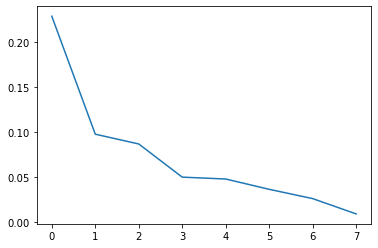

In [ ]:
#Final 

F_meal_df_1, F_no_meal_df_1 = get_final_meal_and_no_meal_datasets('InsulinData.csv', 'CGMData.csv', '%m/%d/%Y %H:%M:%S')
F_meal_df_2, F_no_meal_df_2 = get_final_meal_and_no_meal_datasets('Insulin_patient2.csv', 'CGM_patient2.csv', '%d-%m-%Y %H:%M:%S')

F_meal_df = pd.concat([F_meal_df_1, F_meal_df_2])
F_no_meal_df = pd.concat([F_no_meal_df_1, F_no_meal_df_2])

#Assigning class labels:
F_meal_df['Class'] = 1
F_no_meal_df['Class'] = 0

#Concatenating meal and no-meal data:
F_data_df = pd.concat([F_meal_df, F_no_meal_df])

#Correcting the indices
F_data_df = F_data_df.reset_index().drop(columns = 'index')

#Taking the class lables out
class_labels = F_data_df['Class']
F_data_df.drop(columns = 'Class', inplace = True)

#Normalize
F_data_df_normalized = normalize(F_data_df)

#Principal Component Analysis
X_train = perform_PCA(F_data_df_normalized)

y_train = class_labels

model = svm_classifier(X_train, y_train)
#model = decision_tree_classifier(X_train, y_train)

pickle.dump(model, open('model.pkl', 'wb'))

## K-fold for training validation

In [ ]:
dataset=shuffle(X_train,random_state=1)
labels = y_train

kfold = KFold(n_splits=10,shuffle=True,random_state=1)
scores_rf = []
#model = DecisionTreeClassifier(criterion="entropy")
model = SVC(gamma = 'scale')

for train_index, test_index in kfold.split(dataset):
    train_X, test_X, train_y, test_y = X_train.loc[train_index], X_train.loc[test_index], labels.loc[train_index],labels.loc[test_index]
    print(sum(train_y == 0))
    model.fit(train_X,train_y)
    scores_rf.append(model.score(test_X,test_y))

1906
1911
1910
1904
1900
1907
1908
1905
1918
1902


In [ ]:
print('Prediction score is',np.mean(scores_rf)*100)

Prediction score is 91.09223137527778


## Testing

In [ ]:
model = pickle.load(open("model.pkl", "rb" ))
model

SVC()

In [ ]:
test_data = pd.read_csv('test.csv', header = None, low_memory = False).values.tolist()
#test_data

In [ ]:
F_test_df = extract_features(test_data)
F_test_df

,CGM_Max_Min_Diff,slope_delta_1,slope_delta_1_loc,slope_delta_2,slope_delta_2_loc,slope_delta_3,slope_delta_3_loc,CGM_Max_Min_Time_Diff,fft_2,fft_3,fft_4
0,85,2.6,16,1.3,10,1.2,6,70,6,18,20
1,201,6.6,7,2.5,4,2.1,20,65,22,2,19
2,200,2.0,6,1.9,0,1.3,8,-90,11,13,14
3,74,1.1,8,1.0,20,0.9,1,110,23,1,6
4,78,3.9,16,3.6,17,1.9,7,55,5,19,8
...,...,...,...,...,...,...,...,...,...,...,...
226,19,2.5,6,0.8,16,0.8,17,-80,23,1,17
227,34,2.5,3,0.9,19,0.8,13,-90,6,12,18
228,260,7.7,16,6.9,17,3.6,10,110,1,23,2
229,174,7.7,4,6.9,5,3.4,6,55,3,21,12


In [ ]:
#Normalize
F_test_df_normalized = normalize(F_test_df)

In [ ]:
#Principal Component Analysis

def perform_PCA_for_test_data(dataset):
    pca = get_PCA() #assuming the pca is fit using train data during training
    transformed_dataset = pca.transform(dataset)
    return pd.DataFrame(transformed_dataset)

#X_test = perform_PCA(F_test_df_normalized)
X_test = perform_PCA_for_test_data(F_test_df_normalized)
X_test

,0,1,2,3,4,5,6,7
0,0.420600,0.560577,0.275075,-0.075254,0.369235,0.010585,0.155106,0.142121
1,-0.575314,0.311690,0.230497,0.823516,0.204025,-0.220399,0.717826,0.285106
2,-0.012957,0.269367,-0.315190,0.085181,-0.299566,-0.202839,0.545455,-0.142130
3,-0.460777,-0.374024,0.459071,-0.029786,0.487648,0.663512,0.057330,0.054584
4,0.544752,0.228599,0.613259,-0.085221,0.018845,0.304158,0.376768,0.460254
...,...,...,...,...,...,...,...,...
226,-0.747639,0.314536,0.158243,0.434159,-0.265164,0.326095,-0.254924,0.205497
227,0.110489,0.513436,-0.078887,0.300295,-0.373285,0.586477,-0.194214,0.190216
228,0.856397,0.166671,0.913314,0.181378,-0.073064,0.305167,1.406353,0.676619
229,0.617981,0.231816,-0.088911,0.282968,0.029432,0.108860,1.258577,0.812000


In [ ]:
#Predictions
y_predictions = model.predict(X_test)
y_predictions_df = pd.DataFrame(y_predictions)
y_predictions_df

,0
0,1
1,1
2,0
3,1
4,1
...,...
226,1
227,0
228,1
229,1


In [ ]:
y_predictions_df.to_csv('Results.csv', index = False, header = False)

In [ ]:
sum(y_predictions)

201